In [1]:
import pandas as pd
import numpy as np
import os,sys
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import seaborn as sns
import datetime as dt

In [2]:
fdir = os.path.join(sys.path[0],"data/")
flist = os.listdir(fdir)
DataSet = {}
for file in flist:
    # print(file)
    Coinname = file.replace("coin_", "", 1).replace(".csv","",1)
    # print(Coinname)
    DataSet[Coinname] = pd.read_csv("data/"+file)

In [3]:
for key in DataSet:
    print(key)

Aave
BinanceCoin
Bitcoin
Cardano
ChainLink
Cosmos
CryptocomCoin
Dogecoin
EOS
Ethereum
Iota
Litecoin
Monero
NEM
Polkadot
Solana
Stellar
Tether
Tron
Uniswap
USDCoin
WrappedBitcoin
XRP


In [4]:
coin = "Bitcoin"
# DataSet["Bitcoin"].drop(columns=["SNo","Name","Symbol"])
df = DataSet[coin][['Date','Close']].set_index("Date")
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df.head()

,Close
Date,
2013-04-29 23:59:59,144.539993
2013-04-30 23:59:59,139.000000
2013-05-01 23:59:59,116.989998
2013-05-02 23:59:59,105.209999
2013-05-03 23:59:59,97.750000


<AxesSubplot:xlabel='Date'>

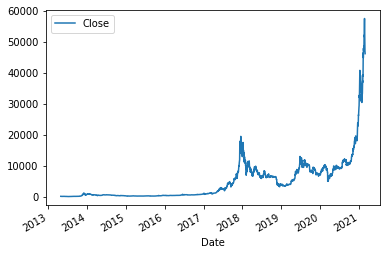

In [6]:
df.plot()

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from random import random
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
dfMonth = DataSet[coin].drop(columns=["SNo","Name","Symbol"]).set_index("Date")
dfMonth.index = pd.to_datetime(dfMonth.index)
dfMonth.sort_index(inplace=True)
dfMonth = dfMonth.resample('M').mean()
dfMonth['Close_box'], lmbda = stats.boxcox(dfMonth.Close)
dfMonth['box_diff_seasonal_3'] = dfMonth.Close_box - dfMonth.Close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(dfMonth.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.019953


Dickey–Fuller test: p=0.631802
Dickey–Fuller test: p=0.000442


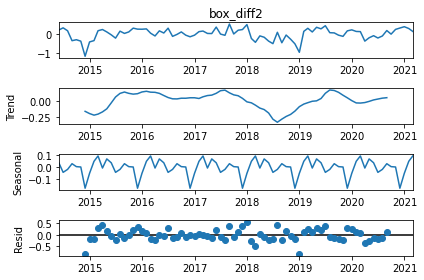

In [7]:
# Seasonal differentiation (12 months)
dfMonth['box_diff_seasonal_12'] = dfMonth.Close_box - dfMonth.Close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(dfMonth.box_diff_seasonal_12[12:])[1])

dfMonth['box_diff2'] = dfMonth.box_diff_seasonal_12 - dfMonth.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(dfMonth.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(dfMonth.box_diff2[13:])[1])

plt.show()

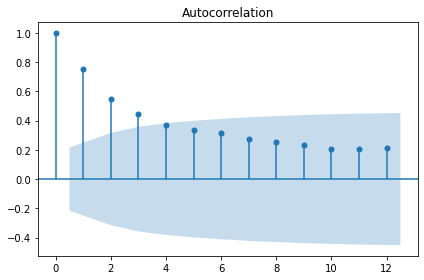

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#autocorrelation_plot(btc_month.Close)
plot_acf(dfMonth.Close[13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

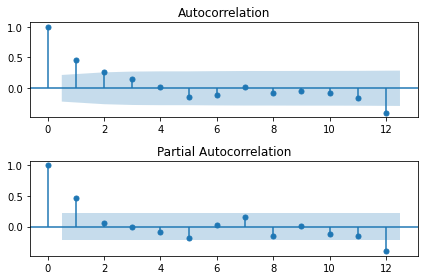

In [9]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(dfMonth.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(dfMonth.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

In [10]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from itertools import product
import warnings
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(dfMonth.Close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [11]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters        aic
3     (1, 0) -26.579614
1     (0, 1) -25.228748
4     (1, 1) -24.607245
6     (2, 0) -24.599110
7     (2, 1) -24.141584


In [12]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              Close_box   No. Observations:                   95
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  15.290
Date:                Wed, 26 May 2021   AIC                            -26.580
Time:                        00:09:18   BIC                            -21.493
Sample:                    04-30-2013   HQIC                           -24.525
                         - 02-28-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4093      0.101      4.038      0.000       0.211       0.608
sigma2         0.0422      0.003     13.470      0.000       0.036       0.048
Ljung-Box (L1) (Q):                   0.05   Jarque-

In [13]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


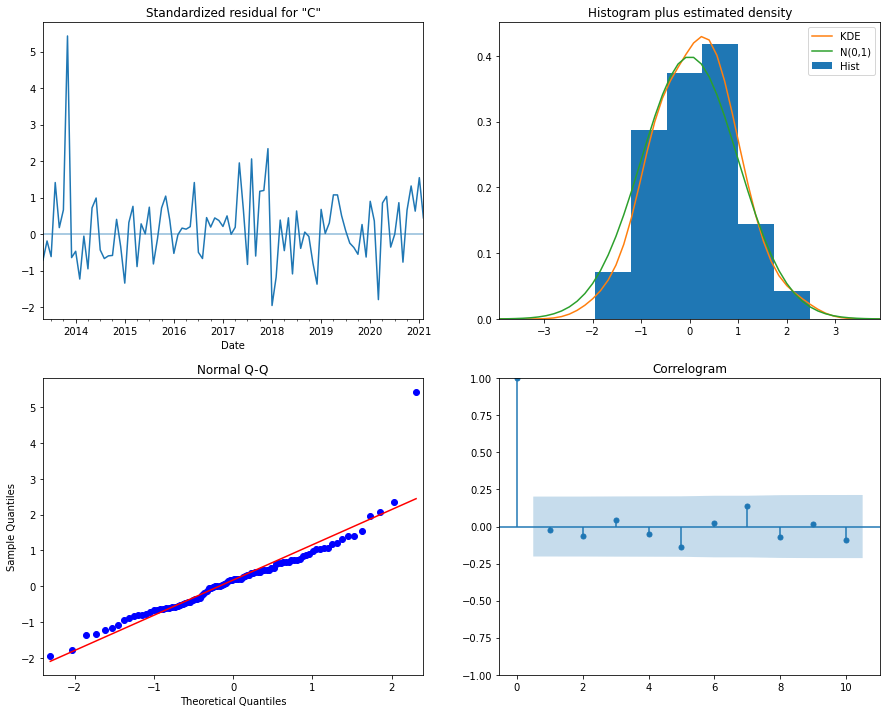

In [14]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [15]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

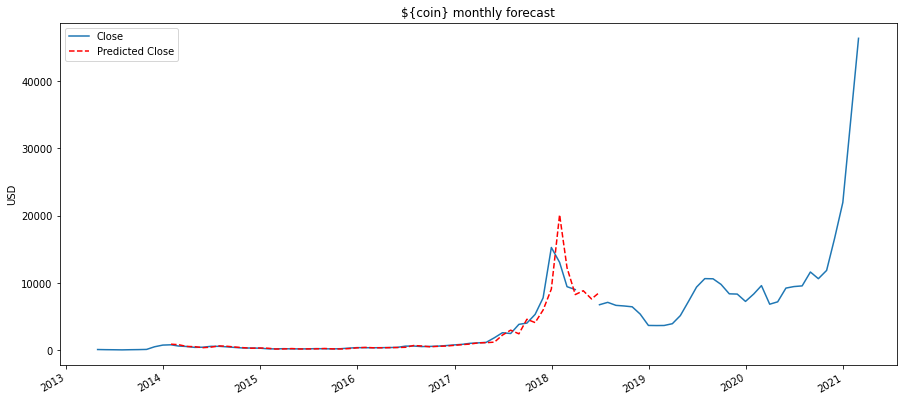

In [16]:
from datetime import datetime, timedelta

# Prediction
df_month_pred = dfMonth[['Close']]
#date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30), 
#             datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30), datetime(2018, 10, 31),
#             datetime(2018, 11, 30), datetime(2018, 12, 31)]
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
future = pd.DataFrame(index=date_list, columns= dfMonth.columns)
df_month_pred = pd.concat([df_month_pred, future])

#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
df_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2014, 1, 31), end=datetime(2018, 6, 30)), lmbda)


plt.figure(figsize=(15,7))
df_month_pred.Close.plot()
df_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('${coin} monthly forecast')
plt.ylabel('USD')
plt.show()

In [17]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
#        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        model = SARIMAX(dfMonth.Close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [18]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters        aic
19  (1, 0, 0, 1) -10.708848
7   (0, 1, 0, 1) -10.117279
21  (1, 0, 1, 1)  -9.023386
25  (1, 1, 0, 1)  -8.810391
37  (2, 0, 0, 1)  -8.788393
                                      SARIMAX Results                                      
Dep. Variable:                           Close_box   No. Observations:                   95
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 4)   Log Likelihood                   8.354
Date:                             Wed, 26 May 2021   AIC                            -10.709
Time:                                     00:10:08   BIC                             -3.209
Sample:                                 04-30-2013   HQIC                            -7.685
                                      - 02-28-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------

In [19]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


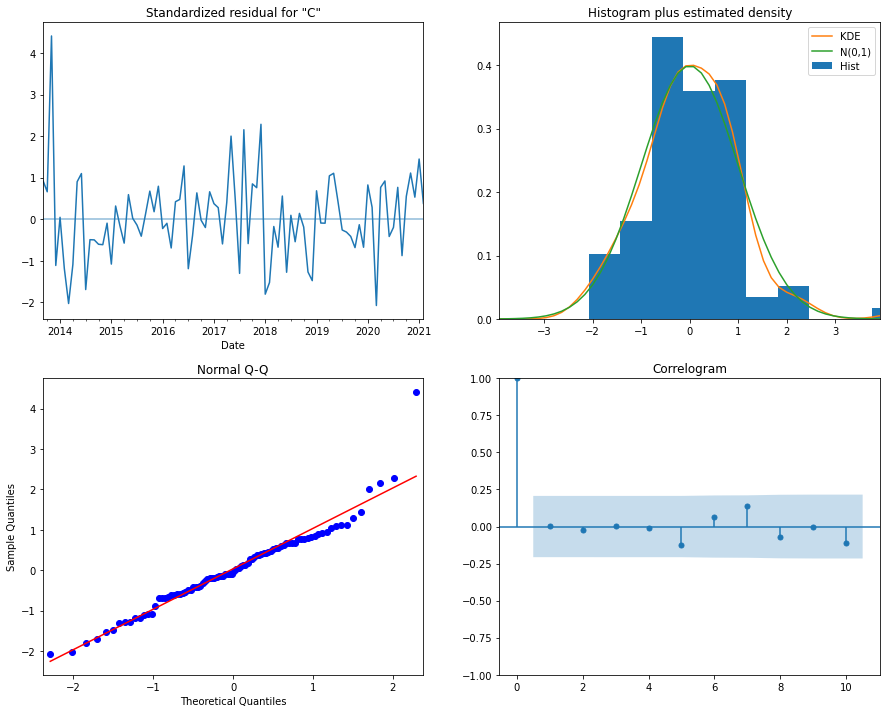

In [20]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Dickey–Fuller test:: p=0.000000


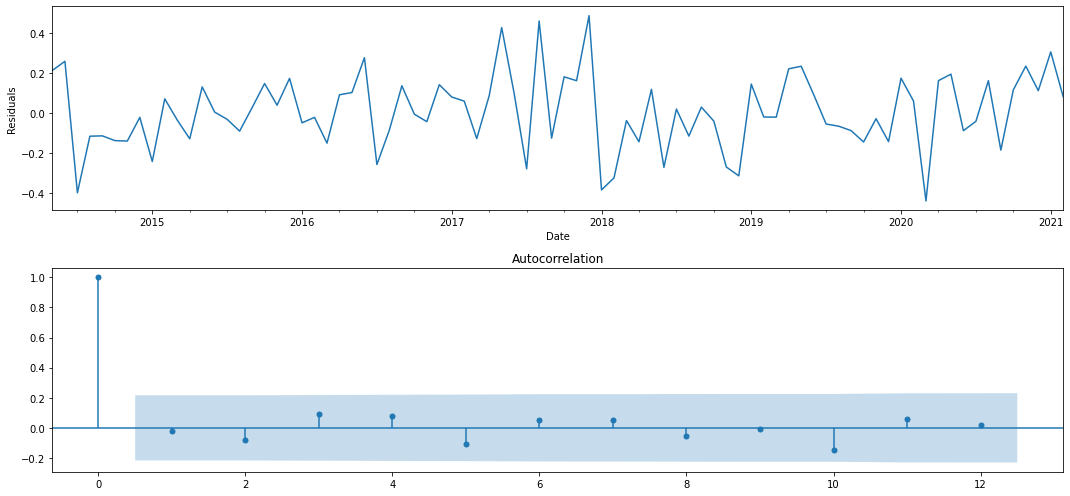

In [21]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
#sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(best_model.resid[13:].values.squeeze(), lags=12, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

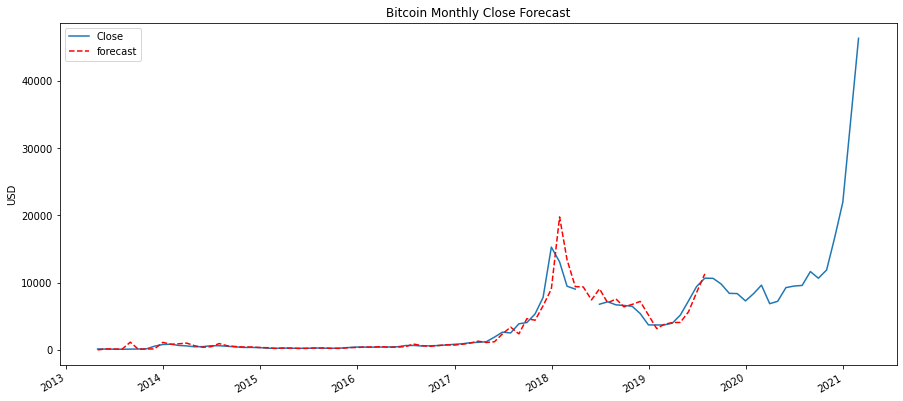

In [22]:
# Prediction
btc_month2 = dfMonth[['Close']]
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
future = pd.DataFrame(index=date_list, columns= dfMonth.columns)
btc_month2 = pd.concat([btc_month2, future])

btc_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)

plt.figure(figsize=(15,7))
btc_month2.Close.plot()
btc_month2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin Monthly Close Forecast')
plt.ylabel('USD')
plt.savefig('bitcoin_monthly_forecast.png')
plt.show()

In [25]:
y_forecasted = btc_month2.forecast
y_truth = btc_month2['2015-01-01':'2017-01-01'].Close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

AssertionError: <class 'numpy.ndarray'>